# **Estimating Airbnb Room Prices with Machine Learning**

Members

1. 6442003826 Krittaporn Unyuang
2. 6442037126 Thanachwan Samretwanich
3. 6442087526 Phooreephat Netsuwan
4. 6442098426 Lalna Ronakornkitanant
5. 6442104526 Silsupha Pittayajumrut



## **Import Libraries**

In [ ]:
# EDA
from google.colab import drive
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Data Preparation
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Modeling
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from hyperopt import hp, fmin, tpe, Trials
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## **1. Exploratory Data Analysis**

### 1.1 Overview

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data sci project/source code/Airbnb_Data.csv')

In [ ]:
df.head()

,id,host_has_profile_pic,host_identity_verified,neighbourhood,room_type,accommodates,bathrooms,beds,price,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews,review_scores_rating,reviews_per_month,day_as_host
0,27934,t,t,Ratchathewi,Entire home/apt,3,1.5,1.0,1903.0,3,90,3.0,90.0,64,4.85,0.45,4989
1,27979,t,f,Bang Na,Private room,2,1.0,2.0,1316.0,1,730,1.0,730.0,0,0.00,0.00,4989
2,28745,t,f,Bang Kapi,Private room,2,1.0,1.0,800.0,60,730,60.0,730.0,0,0.00,0.00,4867
3,820395,t,t,Bang Sue,Entire home/apt,2,1.0,1.0,700.0,7,365,7.0,365.0,13,4.77,0.10,4645
4,1255386,t,f,Dusit,Private room,3,1.0,3.0,7500.0,1,365,1.0,365.0,0,0.00,0.00,3831


In [ ]:
df.shape

(21007, 17)

In [ ]:
# Check for duplicates
df.duplicated().sum()

0

We focus on entire rooms, private rooms, and hotels only. So, we will remove shared room type from this dataframe.

In [ ]:
# exclude shared rooms from df
df = df[df['room_type'] != 'Shared room']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20503 entries, 0 to 21006
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      20503 non-null  int64  
 1   host_has_profile_pic    20503 non-null  object 
 2   host_identity_verified  20503 non-null  object 
 3   neighbourhood           20503 non-null  object 
 4   room_type               20503 non-null  object 
 5   accommodates            20503 non-null  int64  
 6   bathrooms               20503 non-null  float64
 7   beds                    20503 non-null  float64
 8   price                   20503 non-null  float64
 9   minimum_nights          20503 non-null  int64  
 10  maximum_nights          20503 non-null  int64  
 11  minimum_nights_avg_ntm  20503 non-null  float64
 12  maximum_nights_avg_ntm  20503 non-null  float64
 13  number_of_reviews       20503 non-null  int64  
 14  review_scores_rating    20503 non-null  flo

In [ ]:
df.shape

(20503, 17)

In [ ]:
# Check for missing values
df.isnull().sum()

id                        0
host_has_profile_pic      0
host_identity_verified    0
neighbourhood             0
room_type                 0
accommodates              0
bathrooms                 0
beds                      0
price                     0
minimum_nights            0
maximum_nights            0
minimum_nights_avg_ntm    0
maximum_nights_avg_ntm    0
number_of_reviews         0
review_scores_rating      0
reviews_per_month         0
day_as_host               0
dtype: int64

In [ ]:
df.nunique()

id                        20503
host_has_profile_pic          2
host_identity_verified        2
neighbourhood                50
room_type                     3
accommodates                 16
bathrooms                    38
beds                         29
price                      3843
minimum_nights               94
maximum_nights              148
minimum_nights_avg_ntm      279
maximum_nights_avg_ntm      226
number_of_reviews           331
review_scores_rating        142
reviews_per_month           632
day_as_host                3093
dtype: int64

### 1.2 Multicollinearity Test (Lasso)

In [ ]:
df1 = df.copy()

In [ ]:
from sklearn.linear_model import Lasso

X = df1.drop(columns=['price'])
X = X.drop(columns=['neighbourhood'])
X = X.drop(columns=['room_type'])
X = X.drop(columns=['host_has_profile_pic'])
X = X.drop(columns=['host_identity_verified'])
y = df1['price']

lasso_model = Lasso(alpha=0.01)  # Set alpha (regularization strength)
lasso_model.fit(X, y)

feature_names = X.columns[:-1]  # Exclude the target variable column
coefficients = lasso_model.coef_

print("Lasso Coefficients:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef}")

Lasso Coefficients:
id: -1.0166027585179774e-15
accommodates: 846.3225777088729
bathrooms: 741.6787366182107
beds: -286.29261099968977
minimum_nights: 0.43637115639413354
maximum_nights: -0.09226688855862862
minimum_nights_avg_ntm: 15.049018382719174
maximum_nights_avg_ntm: 1.7185172778508825e-06
number_of_reviews: -4.828783963499069
review_scores_rating: -74.01013313223697
reviews_per_month: -49.24407130804445


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.309e+12, tolerance: 6.721e+08
  model = cd_fast.enet_coordinate_descent(


In [ ]:
df1 = df1.drop(columns=['day_as_host'])

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20503 entries, 0 to 21006
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      20503 non-null  int64  
 1   host_has_profile_pic    20503 non-null  object 
 2   host_identity_verified  20503 non-null  object 
 3   neighbourhood           20503 non-null  object 
 4   room_type               20503 non-null  object 
 5   accommodates            20503 non-null  int64  
 6   bathrooms               20503 non-null  float64
 7   beds                    20503 non-null  float64
 8   price                   20503 non-null  float64
 9   minimum_nights          20503 non-null  int64  
 10  maximum_nights          20503 non-null  int64  
 11  minimum_nights_avg_ntm  20503 non-null  float64
 12  maximum_nights_avg_ntm  20503 non-null  float64
 13  number_of_reviews       20503 non-null  int64  
 14  review_scores_rating    20503 non-null  flo

### 1.3 Graph

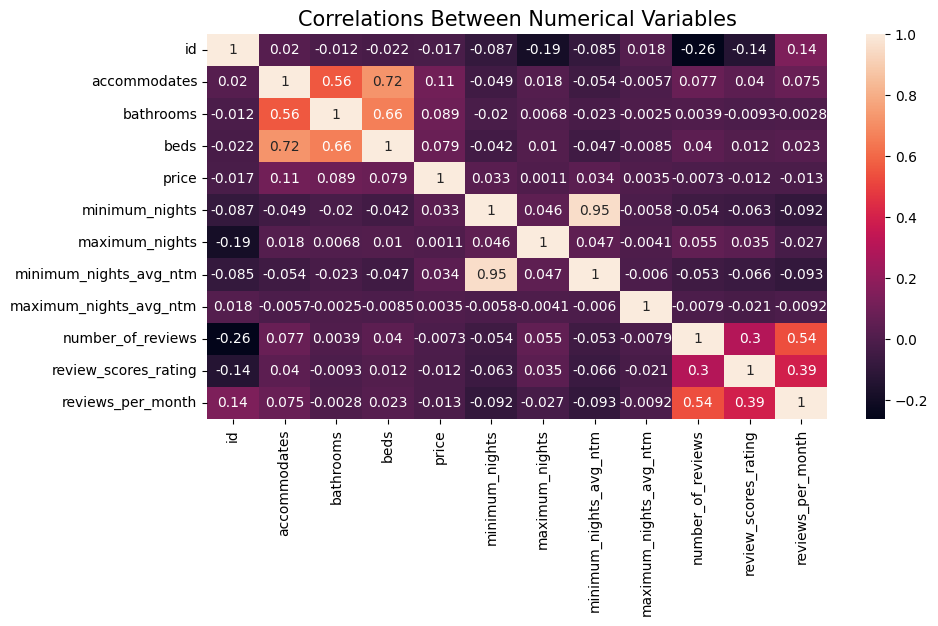

In [ ]:
# Selecting only numerical columns
numerical_columns = df1.select_dtypes(include=['int64', 'float64'])

# Plotting a heatmap of the correlation matrix for numerical columns
plt.figure(figsize=(10, 5))
sns.heatmap(numerical_columns.corr(), annot=True)
plt.title("Correlations Between Numerical Variables", size=15)
plt.show()

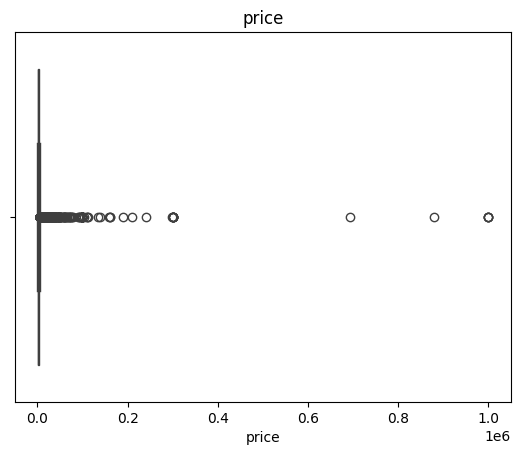

In [ ]:
sns.boxplot(x = df1.price).set_title('price')
plt.show()

### 1.4 Handling Outliers

In [ ]:
df2 = df1.copy()

In [ ]:
# calculate IQR for column Height
Q1 = df2['price'].quantile(0.25)
Q3 = df2['price'].quantile(0.75)
IQR = Q3 - Q1

# identify outliers
threshold = 2
outliers = df2[(df2['price'] < Q1 - threshold * IQR) | (df2['price'] > Q3 + threshold * IQR)]

print(str(len(outliers)))

1572


In [ ]:
# drop rows containing outliers
df2 = df2.drop(outliers.index)

In [ ]:
df2.describe()

,id,accommodates,bathrooms,beds,price,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews,review_scores_rating,reviews_per_month
count,1.893100e+04,18931.000000,18931.000000,18931.000000,18931.000000,18931.000000,18931.000000,18931.000000,1.893100e+04,18931.000000,18931.000000,18931.000000
mean,4.374872e+17,2.883736,1.298056,1.610586,1813.859278,14.254503,592.906027,14.198151,5.679615e+05,17.922297,3.090450,0.664214
std,4.445297e+17,1.716720,1.064456,1.499132,1166.079455,44.211339,834.480381,42.759600,3.489651e+07,44.918173,2.248051,1.292174
min,2.793400e+04,1.000000,0.000000,1.000000,37.000000,1.000000,1.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000
25%,2.897001e+07,2.000000,1.000000,1.000000,995.000000,1.000000,365.000000,1.000000,3.650000e+02,0.000000,0.000000,0.000000
50%,5.533759e+17,2.000000,1.000000,1.000000,1490.000000,2.000000,365.000000,2.000000,1.125000e+03,2.000000,4.580000,0.190000
75%,8.921123e+17,4.000000,1.000000,2.000000,2293.000000,14.000000,1125.000000,15.000000,1.125000e+03,15.000000,4.910000,0.860000
max,1.053584e+18,16.000000,49.000000,50.000000,6008.000000,1115.000000,100000.000000,1115.000000,2.147484e+09,1809.000000,5.000000,62.140000


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18931 entries, 0 to 21006
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      18931 non-null  int64  
 1   host_has_profile_pic    18931 non-null  object 
 2   host_identity_verified  18931 non-null  object 
 3   neighbourhood           18931 non-null  object 
 4   room_type               18931 non-null  object 
 5   accommodates            18931 non-null  int64  
 6   bathrooms               18931 non-null  float64
 7   beds                    18931 non-null  float64
 8   price                   18931 non-null  float64
 9   minimum_nights          18931 non-null  int64  
 10  maximum_nights          18931 non-null  int64  
 11  minimum_nights_avg_ntm  18931 non-null  float64
 12  maximum_nights_avg_ntm  18931 non-null  float64
 13  number_of_reviews       18931 non-null  int64  
 14  review_scores_rating    18931 non-null  flo

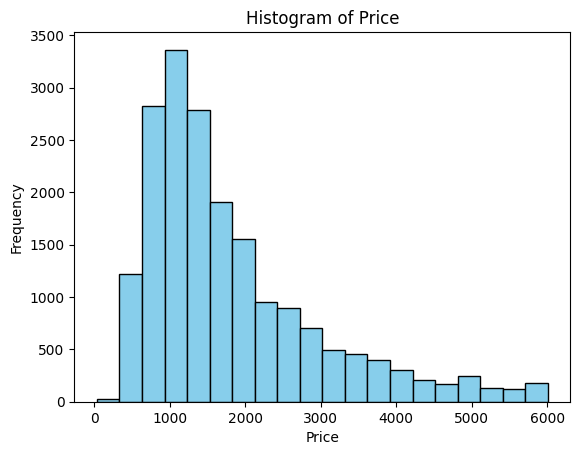

In [ ]:
plt.hist(df2['price'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Price')
plt.show()

In [ ]:
# export the cleaned data
df2.to_csv('Airbnb_Data_1st_revised.csv', index=False)

## **2. Data Preparation**

- Identify and remove unreasonable data in Excel.

In [ ]:
df3 = pd.read_csv('/content/drive/MyDrive/data sci project/source code/Airbnb_Data_2nd_revised.csv')

In [ ]:
df3 = df3.drop(columns=['id'])

### 2.1 One-hot encoding

In [ ]:
df3['host_has_profile_pic'] = df3['host_has_profile_pic'].replace({'t': 1, 'f': 0})
df3['host_identity_verified'] = df3['host_identity_verified'].replace({'t': 1, 'f': 0})

In [ ]:
# one-hot encoding
df3_encoded = pd.get_dummies(df3)

In [ ]:
df3_encoded.head()

,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,beds,price,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,...,neighbourhood_Taling Chan,neighbourhood_Thawi Watthana,neighbourhood_Thon buri,neighbourhood_Thung khru,neighbourhood_Vadhana,neighbourhood_Wang Thong Lang,neighbourhood_Yan na wa,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room
0,1,1,3,1.5,1,1903,3,90,3.0,90.0,...,False,False,False,False,False,False,False,True,False,False
1,1,0,2,1.0,1,800,60,730,60.0,730.0,...,False,False,False,False,False,False,False,False,False,True
2,1,1,2,1.0,1,700,7,365,7.0,365.0,...,False,False,False,False,False,False,False,True,False,False
3,1,1,2,1.0,1,1286,14,180,6.9,180.0,...,False,False,False,False,False,False,False,False,False,True
4,1,1,2,1.0,1,1559,3,1095,3.0,1095.0,...,False,False,False,False,False,False,False,False,False,True


### 2.2 Scaling data

In [ ]:
# Extract the numerical columns
scaler = MinMaxScaler()

# Instantiate the MinMaxScaler
df3_scaled = scaler.fit_transform(df3_encoded)

# Create a DataFrame from the scaled data
df3_scaled = pd.DataFrame(df3_scaled, columns=df3_encoded.columns)
df3_scaled['price'] = df3['price']

# Display the first five rows of the scaled data
df3_scaled.head()

,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,beds,price,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,...,neighbourhood_Taling Chan,neighbourhood_Thawi Watthana,neighbourhood_Thon buri,neighbourhood_Thung khru,neighbourhood_Vadhana,neighbourhood_Wang Thong Lang,neighbourhood_Yan na wa,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room
0,1.0,1.0,0.133333,0.053571,0.0,1903,0.001795,0.00089,0.001795,4.144385e-08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.066667,0.035714,0.0,800,0.052962,0.00729,0.052962,3.394671e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,1.0,0.066667,0.035714,0.0,700,0.005386,0.00364,0.005386,1.695007e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,1.0,0.066667,0.035714,0.0,1286,0.011670,0.00179,0.005296,8.335337e-08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,1.0,0.066667,0.035714,0.0,1559,0.001795,0.01094,0.001795,5.094334e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 2.3 Apply logarithmic transformation to target feature

In [ ]:
df3_scaled['price_log'] = np.log(df3_scaled['price'])

In [ ]:
df3_scaled.to_csv("df_scaled_onehot.csv", index=False)

### 2.4 Train-Test Split

In [ ]:
# MLR
X_scaled = df3_scaled.drop(columns=['price_log','price'])

# SVM
X_encoded = df3_encoded.drop(columns = 'price')

# MLR
y_log = df3_scaled['price_log']

# XGBoost
X = df3.drop(columns=['price'])
y = df3_scaled['price']

In [ ]:
X['neighbourhood'] = X['neighbourhood'].astype('category')
X['room_type'] = X['room_type'].astype('category')

In [ ]:
# MLR
X_train_scaled, X_temp_scaled, y_train_log, y_temp_log = train_test_split(X_scaled, y_log, test_size=0.3, random_state=13)
X_val_scaled, X_test_scaled, y_val_log, y_test_log = train_test_split(X_temp_scaled, y_temp_log, test_size=0.5, random_state=13)

In [ ]:
# SVM
X_train_scaled, X_temp_scaled, y_train_log, y_temp_log = train_test_split(X_scaled, y_log, test_size=0.3, random_state=13)
X_val_scaled, X_test_scaled, y_val_log, y_test_log = train_test_split(X_temp_scaled, y_temp_log, test_size=0.5, random_state=13)

In [ ]:
# XGBoost
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=13)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=13)

## **3. Modeling**

### 3.1 Multiple Linear Regression

#### 3.1.1 Model Assumptions

In [ ]:
ml_model = sm.OLS(y, X_scaled).fit()
predictions = ml_model.predict(X_scaled)
residuals = ml_model.resid

##### Linearity

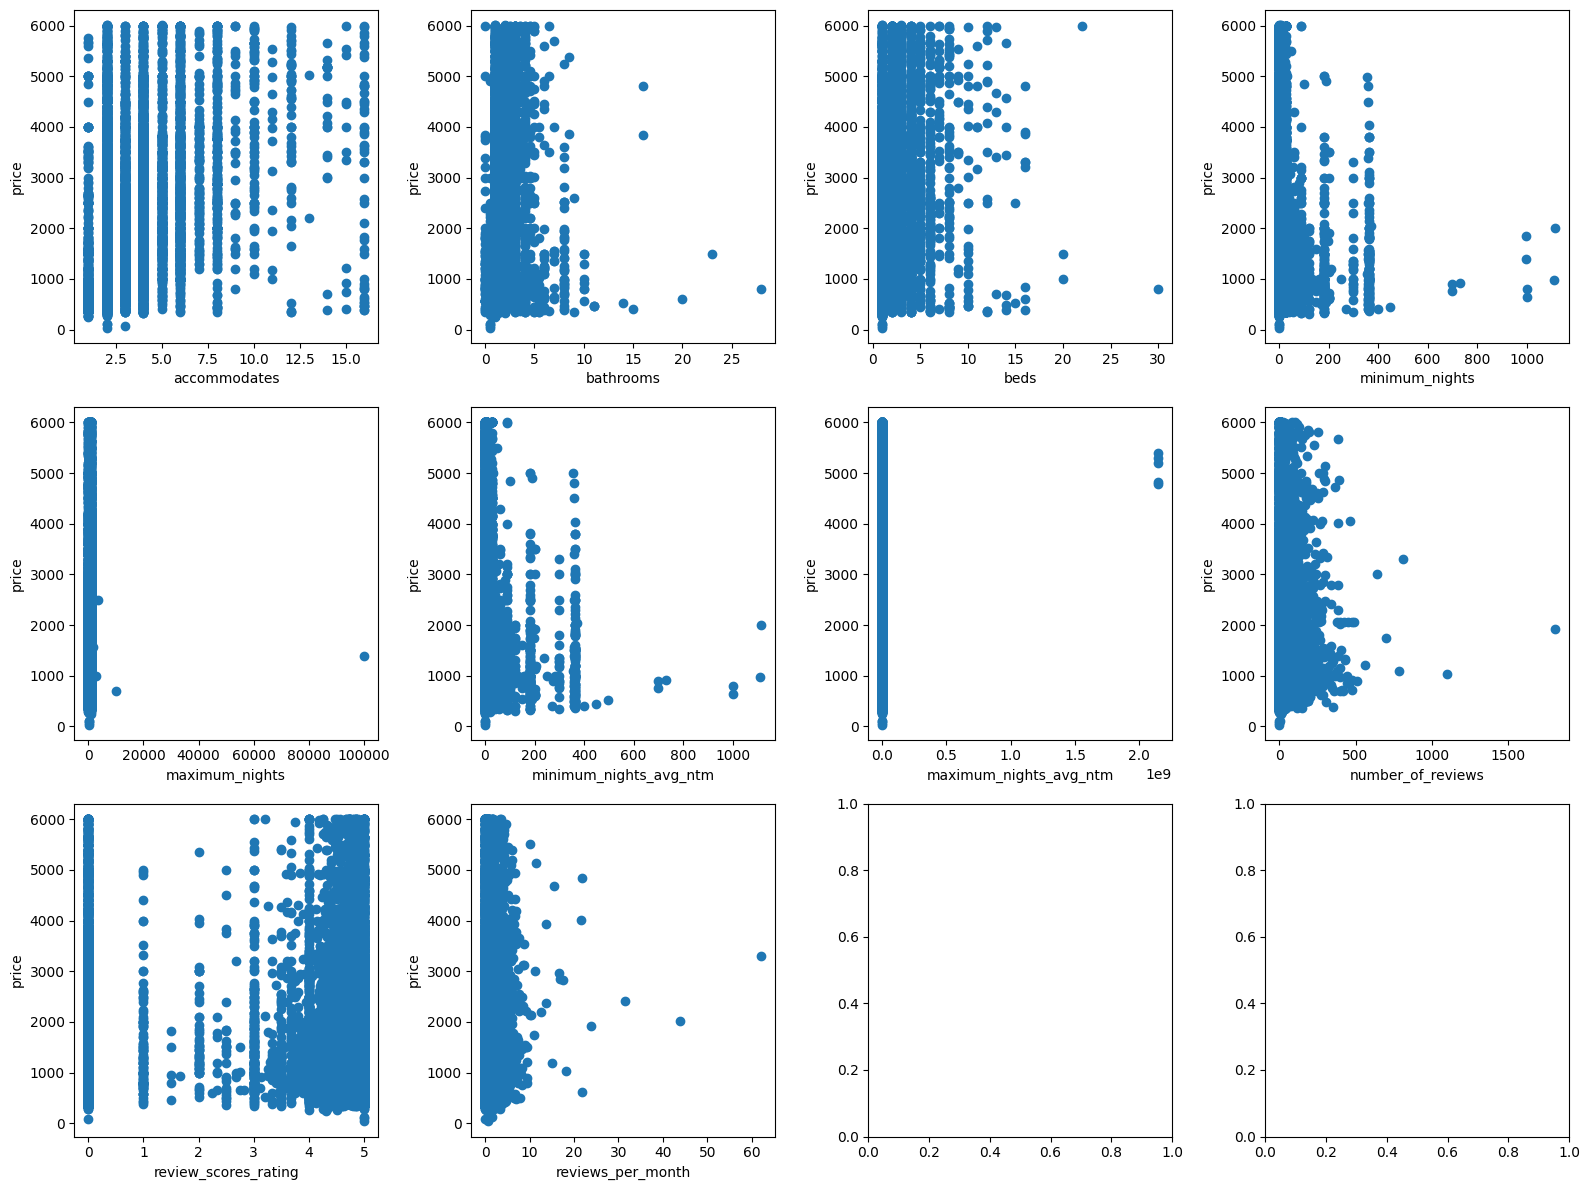

In [ ]:
features = ['accommodates', 'bathrooms', 'beds', 'minimum_nights',
            'maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'number_of_reviews',
            'review_scores_rating', 'reviews_per_month']

# Create a 3x4 subplot grid
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))

# Flatten axes for easier iteration (it becomes a 1D array)
axes = axes.flatten()

# Iterate through features and plot them
for feature, ax in zip(features, axes):
    ax.scatter(X[feature], y)
    ax.set_xlabel(feature)
    ax.set_ylabel('price')

# Adjust spacing
fig.tight_layout()
plt.show()

##### Independence of Errors

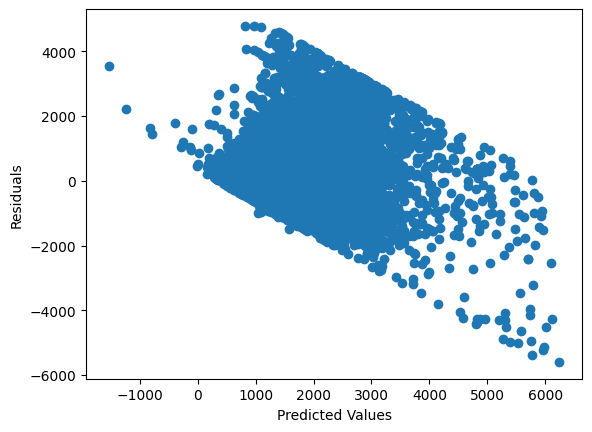

In [ ]:
plt.scatter(predictions, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

##### Normality of Errors

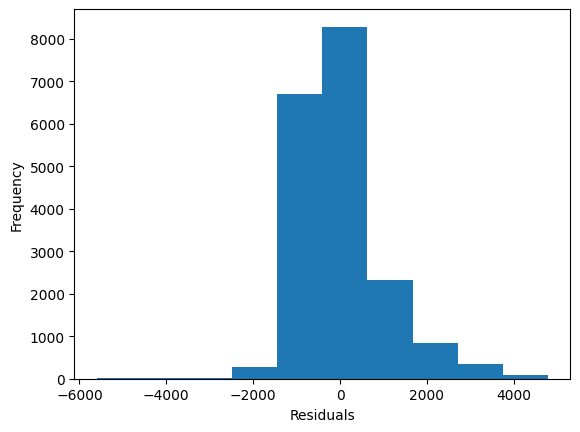

In [ ]:
plt.hist(residuals)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

##### Multicollinearity

###### VIF score

In [ ]:
X_numerical = X_scaled[['host_has_profile_pic', 'host_identity_verified', 'accommodates', 'bathrooms', 'beds', 'minimum_nights', 'maximum_nights',	'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month']]

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_numerical.columns
vif_data["VIF"] = [variance_inflation_factor(X_numerical.values, i) for i in range(len(X_numerical.columns))]
print(vif_data)

                   feature        VIF
0     host_has_profile_pic  12.377809
1   host_identity_verified   9.648789
2             accommodates   5.422632
3                bathrooms   4.906745
4                     beds   3.144322
5           minimum_nights  12.434573
6           maximum_nights   1.535377
7   minimum_nights_avg_ntm  12.505553
8   maximum_nights_avg_ntm   1.000731
9        number_of_reviews   1.671286
10    review_scores_rating   3.718978
11       reviews_per_month   1.956819


###### Handling Multicollinearity

In [ ]:
X_mlr_train = X_train_scaled.drop(columns = ['minimum_nights_avg_ntm'])

X_numerical = X_mlr_train[['host_has_profile_pic', 'host_identity_verified', 'accommodates', 'bathrooms', 'beds', 'minimum_nights', 'maximum_nights', 'maximum_nights_avg_ntm', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month']]

vif_data = pd.DataFrame()
vif_data["feature"] = X_numerical.columns
vif_data["VIF"] = [variance_inflation_factor(X_numerical.values, i) for i in range(len(X_numerical.columns))]
print(vif_data)

                   feature        VIF
0     host_has_profile_pic  14.037699
1   host_identity_verified   9.785741
2             accommodates   5.370181
3                bathrooms   4.746730
4                     beds   3.077382
5           minimum_nights   1.102869
6           maximum_nights   3.115310
7   maximum_nights_avg_ntm   1.000782
8        number_of_reviews   1.722334
9     review_scores_rating   3.694452
10       reviews_per_month   1.911958


In [ ]:
X_mlr_train = X_train_scaled.drop(columns = ['minimum_nights_avg_ntm','host_has_profile_pic'])

X_numerical = X_mlr_train[['host_identity_verified', 'accommodates', 'bathrooms', 'beds', 'minimum_nights', 'maximum_nights', 'maximum_nights_avg_ntm', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month']]

vif_data = pd.DataFrame()
vif_data["feature"] = X_numerical.columns
vif_data["VIF"] = [variance_inflation_factor(X_numerical.values, i) for i in range(len(X_numerical.columns))]
print(vif_data)

                  feature       VIF
0  host_identity_verified  5.184711
1            accommodates  5.227009
2               bathrooms  4.224261
3                    beds  2.957283
4          minimum_nights  1.096134
5          maximum_nights  2.621051
6  maximum_nights_avg_ntm  1.000717
7       number_of_reviews  1.711676
8    review_scores_rating  3.656587
9       reviews_per_month  1.910394


#### 3.1.2 Base Model

In [ ]:
mlr_model = LinearRegression()
mlr_model.fit(X_train_scaled, y_train_log)

In [ ]:
# Evaluate on the training set
y_train_mlr_pred = mlr_model.predict(X_train_scaled)
train_mlr_mape = mean_absolute_percentage_error(np.exp(y_train_log), np.exp(y_train_mlr_pred))
print("MAPE train:", train_mlr_mape)

# Evaluate on the validation set
y_val_mlr_pred = mlr_model.predict(X_val_scaled)
val_mlr_mape = mean_absolute_percentage_error(np.exp(y_val_log), np.exp(y_val_mlr_pred))
print("MAPE val:", val_mlr_mape)

# Evaluate on the test set
y_test_mlr_pred = mlr_model.predict(X_test_scaled)
test_mlr_mape = mean_absolute_percentage_error(np.exp(y_test_log), np.exp(y_test_mlr_pred))
print("MAPE test:", test_mlr_mape)

MAPE train: 0.4217827879403435
MAPE val: 0.4210764156449181
MAPE test: 0.40441859087231985


#### 3.1.3 Lasso Regression

In [ ]:
lasso_model = Lasso(alpha=0.0001)
lasso_model.fit(X_train_scaled, y_train_log)

In [ ]:
# Evaluate on the training set
y_train_lasso_pred = lasso_model.predict(X_train_scaled)
train_lasso_mape = mean_absolute_percentage_error(np.exp(y_train_log), np.exp(y_train_lasso_pred))
print("MAPE train (lasso):", train_lasso_mape)

# Evaluate on the validation set
y_val_lasso_pred = lasso_model.predict(X_val_scaled)
val_lasso_mape = mean_absolute_percentage_error(np.exp(y_val_log), np.exp(y_val_lasso_pred))
print("MAPE val (lasso):", val_lasso_mape)

# Evaluate on the test set
y_test_lasso_pred = lasso_model.predict(X_test_scaled)
test_lasso_mape = mean_absolute_percentage_error(np.exp(y_test_log), np.exp(y_test_lasso_pred))
print("MAPE test (lasso):", test_lasso_mape)

MAPE train (lasso): 0.422793241577879
MAPE val (lasso): 0.4213903740721942
MAPE test (lasso): 0.4054968656669695


#### 3.1.4 Ridge Regression

In [ ]:
ridge_model = Ridge(alpha=0.5)
ridge_model.fit(X_train_scaled, y_train_log)

In [ ]:
# Evaluate on the training set
y_train_ridge_pred = ridge_model.predict(X_train_scaled)
train_ridge_mape = mean_absolute_percentage_error(np.exp(y_train_log), np.exp(y_train_ridge_pred))
print("MAPE train (ridge):", train_ridge_mape)

# Evaluate on the validation set
y_val_ridge_pred = ridge_model.predict(X_val_scaled)
val_ridge_mape = mean_absolute_percentage_error(np.exp(y_val_log), np.exp(y_val_ridge_pred))
print("MAPE val (ridge):", val_ridge_mape)

# Evaluate on the test set
y_test_ridge_pred = ridge_model.predict(X_test_scaled)
test_ridge_mape = mean_absolute_percentage_error(np.exp(y_test_log), np.exp(y_test_ridge_pred))
print("MAPE test (ridge):", test_ridge_mape)

MAPE train (ridge): 0.42215595397350975
MAPE val (ridge): 0.42140411494713115
MAPE test (ridge): 0.4051216464591464


#### 3.1.5 Feature Selection

In [ ]:
# Function to perform backward feature selection
def backward_feature_selection(X, y, significance_level=0.05):
    selected_features = list(X.columns)
    while len(selected_features) > 0:
        # Fit multiple linear regression model using statsmodels
        X_with_constant = sm.add_constant(X[selected_features])
        model = sm.OLS(y, X_with_constant).fit()
        # Get p-values of features
        p_values = model.pvalues.iloc[1:]  # Exclude intercept
        # Identify least significant feature
        max_p_value = p_values.max()
        if max_p_value > significance_level:
            max_p_value_feature = p_values.idxmax()
            selected_features.remove(max_p_value_feature)
        else:
            break
    return selected_features

# Perform backward feature selection
selected_features = backward_feature_selection(X_train_scaled, y_train_log)

# Print selected features
print("Selected Features:", selected_features)

# Train final model using selected features
X_train_selected = X_train_scaled[selected_features]
final_model = sm.OLS(y_train_log, sm.add_constant(X_train_selected)).fit()


Selected Features: ['host_identity_verified', 'accommodates', 'beds', 'maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month', 'neighbourhood_Bang Kapi', 'neighbourhood_Bang Khae', 'neighbourhood_Bang Kho laen', 'neighbourhood_Bang Na', 'neighbourhood_Bang Rak', 'neighbourhood_Bangkok Noi', 'neighbourhood_Bangkok Yai', 'neighbourhood_Chatu Chak', 'neighbourhood_Chom Thong', 'neighbourhood_Din Daeng', 'neighbourhood_Dusit', 'neighbourhood_Huai Khwang', 'neighbourhood_Khlong Sam Wa', 'neighbourhood_Khlong San', 'neighbourhood_Khlong Toei', 'neighbourhood_Lat Krabang', 'neighbourhood_Lat Phrao', 'neighbourhood_Parthum Wan', 'neighbourhood_Phaya Thai', 'neighbourhood_Phra Khanong', 'neighbourhood_Phra Nakhon', 'neighbourhood_Pom Prap Sattru Phai', 'neighbourhood_Pra Wet', 'neighbourhood_Rat Burana', 'neighbourhood_Ratchathewi', 'neighbourhood_Samphanthawong', 'neighbourhood_Sathon', 'neighbourhood_Suanluang', 'n

In [ ]:
X_train_selected = X_train_scaled[selected_features]
y_train_pred = final_model.predict(sm.add_constant(X_train_selected))
train_mape = mean_absolute_percentage_error(np.exp(y_train_log), np.exp(y_train_pred))
print("MAPE train:", train_mape)

X_val_selected = X_val_scaled[selected_features]
y_val_pred = final_model.predict(sm.add_constant(X_val_selected))
val_mape = mean_absolute_percentage_error(np.exp(y_val_log), np.exp(y_val_pred))
print("MAPE val:", val_mape)

X_test_selected = X_test_scaled[selected_features]
y_test_pred = final_model.predict(sm.add_constant(X_test_selected))
test_mape = mean_absolute_percentage_error(np.exp(y_test_log), np.exp(y_test_pred))
print("MAPE test:", test_mape)

MAPE train: 0.4224789064497592
MAPE val: 0.4214987687415199
MAPE test: 0.40515879729147836


### 3.2 Support Vector Machine

#### 3.2.1 Base Model

In [ ]:
svr_model = SVR()
svr_model.fit(X_train_scaled, y_train)

In [ ]:
# Evaluate on the training set
y_train_svr_pred = svr_model.predict(X_train_scaled)
train_svr_mape = mean_absolute_percentage_error(y_train, y_train_svr_pred)
print("SVR MAPE train:", train_svr_mape)

# Evaluate on the val set
y_val_svr_pred = svr_model.predict(X_val_scaled)
val_svr_mape = mean_absolute_percentage_error(y_val, y_val_svr_pred)
print("SVR MAPE val:", val_svr_mape)

# Evaluate on the test set
y_test_svr_pred = svr_model.predict(X_test_scaled)
test_svr_mape = mean_absolute_percentage_error(y_test, y_test_svr_pred)
print("SVR MAPE test:", test_svr_mape)

SVR MAPE train: 0.48930646592897237
SVR MAPE val: 0.4972195719570318
SVR MAPE test: 0.48561438709425886


#### 3.2.2 Hyperopt: Hyperparameter Tuning

In [ ]:
# Define search space for hyperparameters
svr_space = {
    'C': hp.loguniform('C', np.log(0.01), np.log(100)),
    'epsilon': hp.loguniform('epsilon', np.log(0.01), np.log(1)),
    'kernel': hp.choice('kernel', ['rbf', 'poly']),
    'gamma': hp.loguniform('gamma', np.log(0.001), np.log(1)),  # For 'rbf' kernel
    'degree': hp.quniform('degree', 2, 6, 1)  # For 'poly' kernel
}

In [ ]:
# Define objective function to minimize
def svr_objective(params):
    params['degree'] = int(params['degree'])  # Convert degree to integer
    svr_model = SVR(**params)
    # Perform cross-validation with negative MAPE as scoring metric
    svr_model.fit(X_train_scaled, y_train)
    y_pred = svr_model.predict(X_val_scaled)
    mape = mean_absolute_percentage_error(y_pred, y_val)
    return mape

In [ ]:
# Create Trials object to keep track of results
svr_trials = Trials()

In [ ]:
# Use Tree Parzen Estimator (TPE) algorithm for optimization
best = fmin(fn=svr_objective, space=svr_space, algo=tpe.suggest, max_evals=100, trials=svr_trials)

print("Best Hyperparameters:", best)

100%|██████████| 100/100 [18:22<00:00, 11.03s/trial, best loss: 0.42276581598104135]
Best Hyperparameters: {'C': 98.04559668972055, 'degree': 3.0, 'epsilon': 0.027451360229540166, 'gamma': 0.6949817235579541, 'kernel': 1}


In [ ]:
best['degree'] = best['degree'].astype('int')
best['kernel'] = 'rbf'
final_svr_model = SVR(**best)
final_svr_model.fit(X_train_scaled, y_train)

In [ ]:
# Evaluate on the training set
y_train_tn_svr_pred = final_svr_model.predict(X_train_scaled)
train_tn_svr_mape = mean_absolute_percentage_error(y_train, y_train_tn_svr_pred)
print("SVR MAPE train (tuning):", train_tn_svr_mape)

# Evaluate on the val set
y_val_tn_svr_pred = final_svr_model.predict(X_val_scaled)
val_tn_svr_mape = mean_absolute_percentage_error(y_val, y_val_tn_svr_pred)
print("SVR MAPE val (tuning):", val_tn_svr_mape)

# Evaluate on the test set
y_test_tn_svr_pred = final_svr_model.predict(X_test_scaled)
test_tn_svr_mape = mean_absolute_percentage_error(y_test, y_test_tn_svr_pred)
print("SVR MAPE test (tuning):", test_tn_svr_mape)

SVR MAPE train (tuning): 0.3892403603643615
SVR MAPE val (tuning): 0.39752115074690264
SVR MAPE test (tuning): 0.3895948988878577


#### 3.2.3 Model Improvement Comparison

In [ ]:
svr_performance_data = {
    'Before Tuning': {'Train': train_svr_mape, 'Validation': val_svr_mape, 'Test': test_svr_mape},
    'After Tuning': {'Train': train_tn_svr_mape, 'Validation': val_tn_svr_mape, 'Test': test_tn_svr_mape}
}

svr_pfm_df = pd.DataFrame(svr_performance_data)

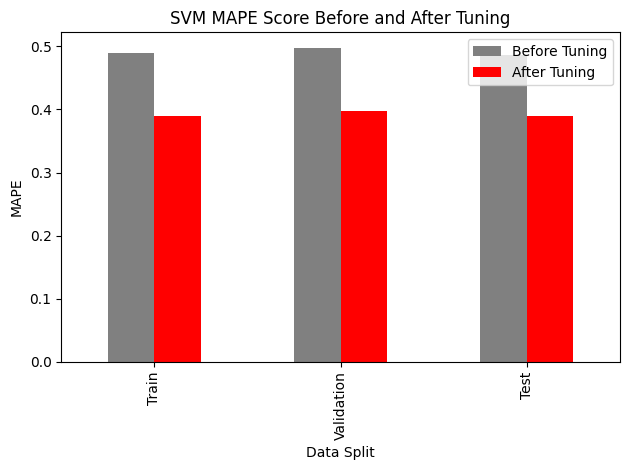

In [ ]:
svr_pfm_df.plot.bar(color=['grey', 'red'])

# Labels and Formatting
plt.xlabel('Data Split')
plt.ylabel('MAPE')
plt.title('SVM MAPE Score Before and After Tuning')
plt.legend(['Before Tuning', 'After Tuning'])
plt.tight_layout()  # Prevents labels from overlapping
plt.show()


### 3.3 XGBoost

#### 3.3.1 Base Model

In [ ]:
xgb_model = XGBRegressor(enable_categorical=True, random_state=13)
xgb_model.fit(X_train, y_train)

In [ ]:
# Evaluate on the training set
y_train_xgb_pred = xgb_model.predict(X_train)
train_xgb_mape = mean_absolute_percentage_error(y_train, y_train_xgb_pred)
print("MAPE train:", train_xgb_mape)

# Evaluate on the val set
y_val_xgb_pred = xgb_model.predict(X_val)
val_xgb_mape = mean_absolute_percentage_error(y_val, y_val_xgb_pred)
print("MAPE val:", val_xgb_mape)

# Evaluate on the test set
y_test_xgb_pred = xgb_model.predict(X_test)
test_xgb_mape = mean_absolute_percentage_error(y_test, y_test_xgb_pred)
print("MAPE test:", test_xgb_mape)

MAPE train: 0.27424370561562283
MAPE val: 0.3933340924415549
MAPE test: 0.40186200077529227


#### 3.3.2 Hyperopt: Hyperparameter Tuning

In [ ]:
# Define search space for hyperparameters
xgb_space={'max_depth': hp.quniform("max_depth", 3, 20, 1),
        'gamma': hp.uniform ('gamma', 0,0.5),
        'reg_alpha': hp.uniform('reg_alpha', 0, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'colsample_bylevel' : hp.uniform('colsample_bylevel', 0.5,1),
        'colsample_bynode' : hp.uniform('colsample_bynode', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 80, 200, 5),
        'max_leaves': hp.quniform('max_leaves', 1, 70, 1),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
        'enable_categorical': True,
        'eval_metric': 'mape',
    }

In [ ]:
# Define objective function to minimize
def xgb_objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['max_leaves'] = int(params['max_leaves'])
    params['n_estimators'] = int(params['n_estimators'])
    xgb_model = XGBRegressor(**params, random_state=13)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_val)
    mape = mean_absolute_percentage_error(y_val, y_pred)
    return mape

In [ ]:
# Create Trials object to keep track of results
xgb_trials = Trials()

In [ ]:
# Use Tree Parzen Estimator (TPE) algorithm for optimization
xgb_best_params = fmin(fn=xgb_objective,
            space=xgb_space,
            algo=tpe.suggest,
            max_evals=2000,
            trials=xgb_trials)

print(xgb_best_params)

100%|█████████▉| 1999/2000 [15:03<00:01,  1.81s/trial, best loss: 0.3827332569304296]
{'colsample_bylevel': 0.7497972169144802, 'colsample_bynode': 0.7838476394534574, 'colsample_bytree': 0.9753417345093047, 'gamma': 0.3965205097267226, 'learning_rate': 0.08267600171588996, 'max_depth': 13.0, 'max_leaves': 70.0, 'min_child_weight': 5.0, 'n_estimators': 195.0, 'reg_alpha': 0.484410766621625, 'reg_lambda': 0.29886974444279535, 'subsample': 0.8212168855400586}


In [ ]:
xgb_best_params['max_depth'] = int(xgb_best_params['max_depth'])
xgb_best_params['max_leaves'] = int(xgb_best_params['max_leaves'])
xgb_best_params['n_estimators'] = int(xgb_best_params['n_estimators'])

final_xgb_model = XGBRegressor(**xgb_best_params, enable_categorical = True, eval_metric = 'mape', booster = 'dart')
final_xgb_model.fit(X_train, y_train)

In [ ]:
# Evaluate on the training set
y_train_tn_xgb_pred = final_xgb_model.predict(X_train)
train_tn_xgb_mape = mean_absolute_percentage_error(y_train, y_train_tn_xgb_pred)
print("XGBoost MAPE train (tuning):", train_tn_xgb_mape)

# Evaluate on the val set
y_val_tn_xgb_pred = final_xgb_model.predict(X_val)
val_tn_xgb_mape = mean_absolute_percentage_error(y_val, y_val_tn_xgb_pred)
print("XGBoost MAPE val (tuning):", val_tn_xgb_mape)

# Evaluate on the test set
y_test_tn_xgb_pred = final_xgb_model.predict(X_test)
test_tn_xgb_mape = mean_absolute_percentage_error(y_test, y_test_tn_xgb_pred)
print("XGBoost MAPE test (tuning):", test_tn_xgb_mape)

XGBoost MAPE train (tuning): 0.29895263661472704
XGBoost MAPE val (tuning): 0.39235662818049316
XGBoost MAPE test (tuning): 0.3805159236057284


#### 3.3.3 Model Improvement Comparison

In [ ]:
xgb_performance_data = {
    'Before Tuning': {'Train': train_xgb_mape, 'Validation': val_xgb_mape, 'Test': test_xgb_mape},
    'After Tuning': {'Train': train_tn_xgb_mape, 'Validation': val_tn_xgb_mape, 'Test': test_tn_xgb_mape}
}

xgb_pfm_df = pd.DataFrame(xgb_performance_data)

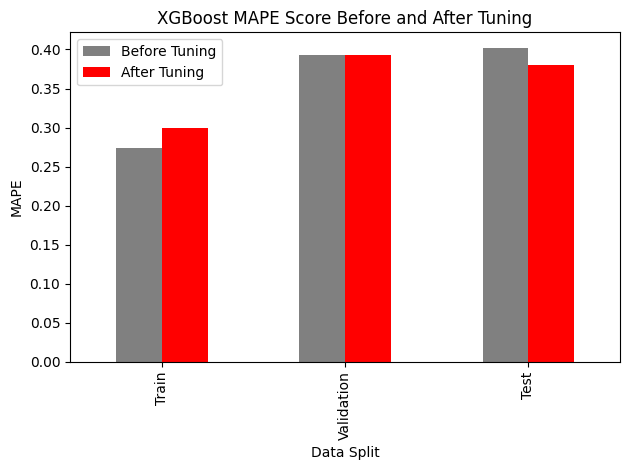

In [ ]:
xgb_pfm_df.plot.bar(color=['grey', 'red'])

# Labels and Formatting
plt.xlabel('Data Split')
plt.ylabel('MAPE')
plt.title('XGBoost MAPE Score Before and After Tuning')
plt.legend(['Before Tuning', 'After Tuning'])
plt.tight_layout()  # Prevents labels from overlapping
plt.show()

## **4. Conclusion**

### 4.1 Model Comparison

In [ ]:
from sklearn.metrics import mean_absolute_error

# mape
mlr_mape = mean_absolute_percentage_error(np.exp(y_test_log), np.exp(mlr_model.predict(X_test_scaled)))
svr_mape = mean_absolute_percentage_error(y_test, final_svr_model.predict(X_test_scaled))
xgb_mape = mean_absolute_percentage_error(y_test, final_xgb_model.predict(X_test))

# mae
mlr_mae = mean_absolute_error(np.exp(y_test_log), np.exp(mlr_model.predict(X_test_scaled)))
svr_mae = mean_absolute_error(y_test, final_svr_model.predict(X_test_scaled))
xgb_mae = mean_absolute_error(y_test, final_xgb_model.predict(X_test))

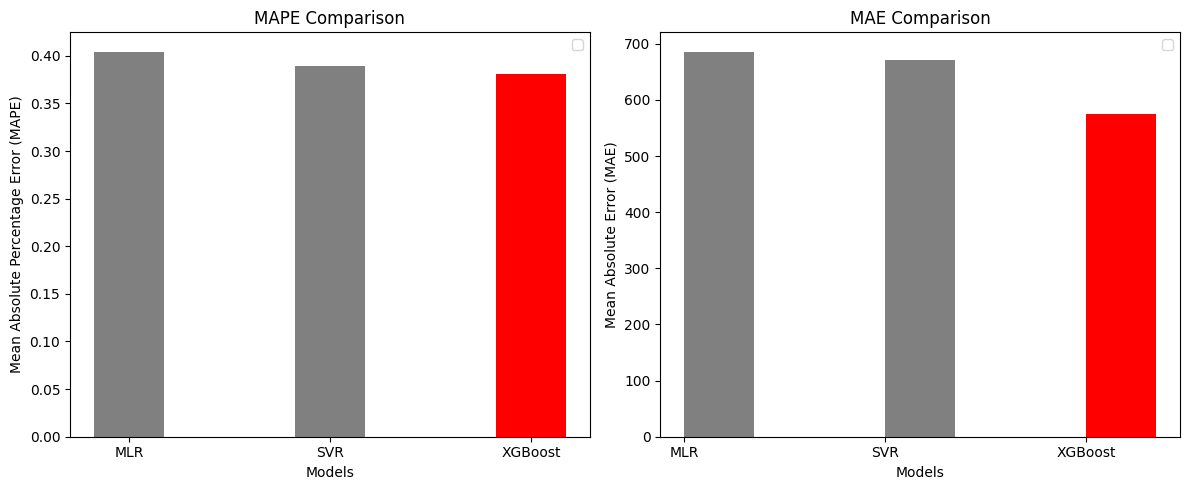

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Bar width
width = 0.35

# Define colors
model_colors = ['grey', 'grey', 'red']  # XGBoost in red

# MAPE Graph
models = ['MLR', 'SVR', 'XGBoost']
x_pos = np.arange(len(models))
bars1 = ax1.bar(x_pos, [mlr_mape, svr_mape, xgb_mape], width, color=model_colors)
ax1.set_xlabel('Models')
ax1.set_ylabel('Mean Absolute Percentage Error (MAPE)')
ax1.set_title('MAPE Comparison')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models)
ax1.legend()

# MAE Graph
bars2 = ax2.bar(x_pos + width, [mlr_mae, svr_mae, xgb_mae], width, color=model_colors)
ax2.set_xlabel('Models')
ax2.set_ylabel('Mean Absolute Error (MAE)')
ax2.set_title('MAE Comparison')
ax2.set_xticks(x_pos + width / 2)
ax2.set_xticklabels(models)
ax2.legend()

# Adjust layout for better visibility
fig.tight_layout()
plt.show()

### 4.2 Features Importance

In [ ]:
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': final_xgb_model.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

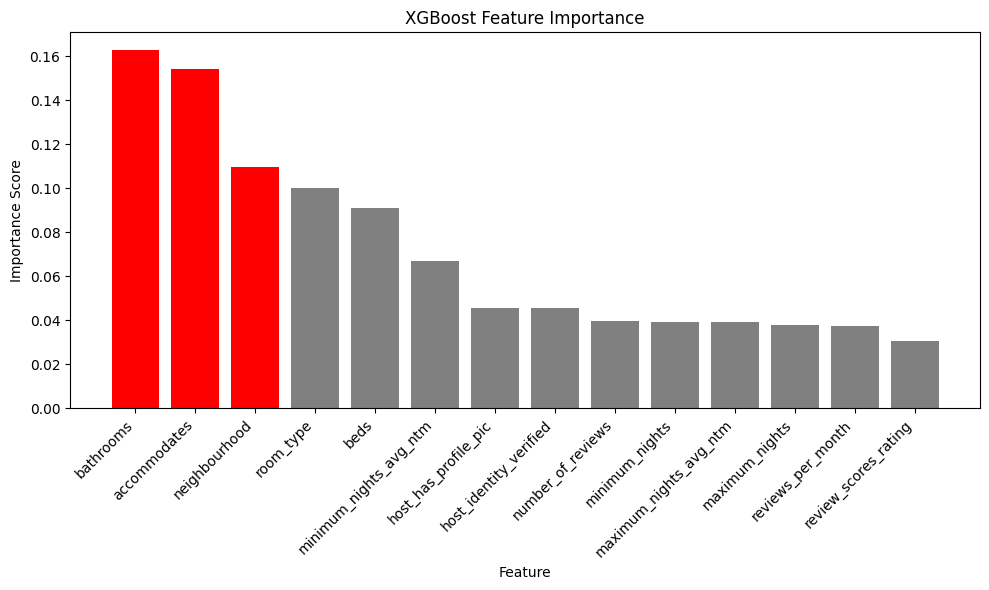

In [ ]:
# Get the number of features to highlight red
num_top_features = 3

# Define colors based on importance ranking
colors = ['red'] * num_top_features + ['grey'] * (len(importance_df) - num_top_features)

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], color=colors)
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('XGBoost Feature Importance')

# Rotate x-axis labels for better readability with many features
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

### 4.3 Export Model

In [ ]:
final_xgb_model.save_model("airbnb_xgboost_model.json")

## **5. Deployment**

- Using Streamlit to create a prototype Airbnb accommodation prediction interface for our model.